In [2]:
import subprocess
import argparse
import numpy as np 
import netCDF4 as netcdf4 
import matplotlib 
import matplotlib.pyplot as plt 
import xarray as xr

In [3]:
# Function definitions
def ilevel(numlevel):
    return np.arange(numlevel,dtype=float)/float(numlevel-1)
    


# input files
idir = '/glade/derecho/scratch/marielj/archive/hillslope-wte-calib-seanmods/lnd/hist/'
sitename = 'MEF_lagg'

# datm data begins in 2011
yr1, yr2 = 2011, 2017
ttag = ','.join(str(y) for y in range(yr1,yr2+1))
ttag = '{'+ttag+'}'
            
command = 'ls '+idir+'*clm2.h2.'+ttag+'*.nc'    
h2files = subprocess.Popen(command,stdout=subprocess.PIPE,shell='True').communicate()[0].strip().decode().split('\n')
command = 'ls '+idir+'*clm2.h3.'+ttag+'*.nc'    
h3files = subprocess.Popen(command,stdout=subprocess.PIPE,shell='True').communicate()[0].strip().decode().split('\n')

# Select hillslope and column
f1 = netcdf4.Dataset(h3files[0], 'r')
nmaxcols = len(f1.dimensions['max_columns_hillslope']) 
nhillslope = len(f1.dimensions['nhillslope']) 
f1.close()
ncol_per_hillslope = int(nmaxcols//nhillslope)

# Read in variables
hm = len(h3files)
for t in range(hm):
    ifile = h3files[t]
    #print(ifile)
    f1 = netcdf4.Dataset(ifile, 'r')
    if t == 0:
        tm0     = len(f1.dimensions['time'])
        nlevsoi = len(f1.dimensions['levsoi'])
        lon = np.asarray(f1.variables['lon'][:,]) 
        lat = np.asarray(f1.variables['lat'][:,])
        pt = [lon[0],lat[0]]
        lonstr = f'{lon[0]:.2f}'
        latstr = f'{lat[0]:.2f}'
        coordlabel = lonstr+'E_'+latstr+'N'
        print(coordlabel)
        h_index= np.asarray(f1.variables['hillslope_index'][:,]) 
        nactualcols = int(np.sum(np.where(h_index > 0,1,0)))
        
        fv = f1.variables['landfrac'].getncattr('_FillValue')
        ref_year = int(f1.variables['time'].units.split()[2].split('-')[0])

        hslp_index = f1.variables['hillslope_index'][:,]
        hslp_elev = f1.variables['hillslope_elev'][:,]
        hslp_dist = f1.variables['hillslope_distance'][:,]
        hslp_area = f1.variables['hillslope_area'][:,]
        hslp_width = f1.variables['hillslope_width'][:,]
        hslp_aspect = f1.variables['hillslope_aspect'][:,]
        hslp_pftndx = f1.variables['pfts1d_itype_veg'][:,]

        pfts1d_wtcol = f1.variables['pfts1d_wtcol'][:,]
        pfts1d_ci = f1.variables['pfts1d_ci'][:,]
        cids = np.unique(pfts1d_ci)

        tm = hm * tm0
        time  = np.zeros((tm))
        rain = np.zeros((nactualcols,tm))
        snow = np.zeros((nactualcols,tm))
        qvegt = np.zeros((nactualcols,tm))
        qsoil = np.zeros((nactualcols,tm))
        qvege = np.zeros((nactualcols,tm))
        h2osoil = np.zeros((nactualcols,tm))

    t1, t2 = t*tm0, (t+1)*tm0
    #print(t,t1,t2)
        
    rain[:,t1:t2]  = f1.variables['RAIN'][:,].T
    snow[:,t1:t2]  = f1.variables['SNOW'][:,].T
    h2osoil[:,t1:t2] = f1.variables['H2OSOI'][:,3,].T

    for nc in range(nactualcols):

        x = np.sum((f1.variables['QVEGT'][:,].T)[pfts1d_ci==cids[nc],] * np.outer(pfts1d_wtcol[pfts1d_ci==cids[nc],],np.ones(tm0)),axis=0)
        qvegt[nc,t1:t2]  = x
        x = np.sum((f1.variables['QSOIL'][:,].T) [pfts1d_ci==cids[nc],]* np.outer(pfts1d_wtcol[pfts1d_ci==cids[nc],],np.ones(tm0)),axis=0)
        qsoil[nc,t1:t2]  = x
        # should have output canopy evaporation...
    
    time[t1:t2] = np.asarray(f1.variables['time'][:,])

    f1.close()
    
        
# convert units
flux_units = 'mm/day'
sf = 24*3600
qvegt = qvegt * sf
qsoil = qsoil * sf
#qvege = qvege * sf
rain = rain * sf
snow = snow * sf

# shift monthly time values by to center of month
time -= 15
ytime = time/365 + ref_year
y1 = np.floor(np.min(ytime)).astype(int)
y2 = np.floor(np.max(ytime)).astype(int)
ytime_ticks = [y for y in range(y1,y2+1)]
ytime_ticklabels = [str(y) for y in range(y1,y2+1)]

for t in range(hm):
    ifile = h2files[t]
    f1 = netcdf4.Dataset(ifile, 'r')
    if t == 0:
        tm0     = len(f1.dimensions['time'])
        tm = hm * tm0
        qdischarge = np.zeros((tm))
        
    t1, t2 = t*tm0, (t+1)*tm0

    qdischarge[t1:t2]  = sf*np.squeeze(f1.variables['QRUNOFF'][:,])

    f1.close()

266.51E_47.56N


In [4]:
# read in observed water table
if 1==1:
    dpm =[31,28,31,30,31,30,31,31,30,31,30,31]
    obsfile = './MEF_daily_peatland_water_table.csv'
    sdata = []
    with open(obsfile,'r') as f1:
        for tmp in f1:
            sdata.append(tmp.strip())

    stime, szwt = [],[]
    oref_year = int(sdata[1].split(',')[1].split('-')[0])
    for tmp in sdata[1:]:
        x = tmp.split(',')
        if x[0].strip('"') == 'S2':
            y,m,d = [int(i) for i in x[1].split('-')]
            t = 365*(y-oref_year)+d
            if m > 1:
                t += np.sum(dpm[:m-1])
            stime.append(t)
            szwt.append(float(x[2]))

    otime = np.asarray(stime)/365 + oref_year
    zsfc = 422.27 # guess-timate of surface elevation
    ozwt = (zsfc - np.asarray(szwt))

In [5]:
# read in observed streamflow
if 1==1:
    dpm =[31,28,31,30,31,30,31,31,30,31,30,31]
    obsfile = './Streamflow_daily.csv'
    sdata = []
    with open(obsfile,'r') as f1:
        for tmp in f1:
            sdata.append(tmp.strip())

    stime, sflow = [],[]
    oref_year = int(sdata[1].split(',')[0].split('-')[0])
    for tmp in sdata[1:]:
        x = tmp.split(',')
        if x[1] == 'S2':
            y,m,d = [int(i) for i in x[0].split('-')]
            t = 365*(y-oref_year)+d
            if m > 1:
                t += np.sum(dpm[:m-1])
            stime.append(t)
            sflow.append(float(x[2]))

    oftime = np.asarray(stime)/365 + oref_year
    sf = 1e-3 # convert from L/s to m3/s
    oflow = np.asarray(sflow)*sf

In [6]:
# read observed latent heat flux
if 1==1:
    lhfile = '/glade/derecho/scratch/swensosc/Ameriflux/AMF_US-MBP_set.nc'
    f1 = netcdf4.Dataset(lhfile, 'r')
    oet_time = f1.variables['time'][:,]
    x = f1.variables['time'].units.split()
    oet_ref_year = float(f1.variables['time'].units.split()[2].split('-')[0])
    oet = np.asarray(f1.variables['LE'][:,])
    f1.close()
    oet_mask = (oet > -9999)
    oet[oet <= -9999] = 0
    lhv = 2.5e6 #J/kg latent heat of vaporization
    sphh = 1800 # seconds per half hour
    oet = oet/lhv * sphh
    oet_ytime = oet_time/365+oet_ref_year

    # create daily climatology
    oet_daily_climo = np.zeros(365)
    oet_daily_time  = np.arange(365)+0.5
    for d in range(365):
        l1 = np.logical_and(np.floor(np.mod(oet_time,365)) >= d,np.floor(np.mod(oet_time,365)) < (d+1))
        ind = np.where(np.logical_and(l1,oet_mask))[0]

        oet_daily_climo[d] = np.mean(oet[ind])*48 # mean hh value x 48 hh per day

In [14]:
##0
# Water budget
irain = np.zeros((nactualcols,tm))
isnow = np.zeros((nactualcols,tm))
i0 = 0
# water year
if 1==2:
    offset = 365-270
else:
    offset = 0
for i in range(1,tm):
    if np.mod(time[i]+offset,365) < np.mod(time[i-1]+offset,365):
        i0 = i-1
        #print('i0 ',i0,i)
    irain[:,i] = np.sum(rain[:,i0:i-1],axis=1)
    isnow[:,i] = np.sum(snow[:,i0:i-1],axis=1)

iet = np.zeros((nactualcols,tm))
iqdischarge = np.zeros((tm))
offset = 0
for i in range(1,tm):
    if np.mod(time[i]+offset,365) < np.mod(time[i-1]+offset,365):
        i0 = i-1
    #iet[:,i] = np.sum(qvegt[:,i0:i-1]+qvege[:,i0:i-1]+qsoil[:,i0:i-1],axis=1)
    iet[:,i] = np.sum(qvegt[:,i0:i-1]+qsoil[:,i0:i-1],axis=1)
    iqdischarge[i] = np.sum(qdischarge[i0:i-1])

# annual values
ann_precip = []
ann_et = []
ann_discharge = []
for n in range(hm):
    l1 = np.logical_and(ytime >= n+yr1,ytime < n+1+yr1)
    ann_precip.append(np.max(irain[2,l1]+isnow[2,l1]))
    ann_et.append(1.e-3*(hslp_area[0]*np.max(iet[0,l1])+hslp_area[1]*np.max(iet[1,l1])+hslp_area[2]*np.max(iet[2,l1])))
    ann_discharge.append(np.max(iqdischarge[l1]))

spd = 3600*24 # seconds per day
ann_obs_streamflow = []
for n in range(hm):
    l1 = np.logical_and(oftime >= n+yr1,oftime < n+1+yr1)
    ann_obs_streamflow.append(np.sum(oflow[l1])*spd)

# mean annual values
mean_annual_precip = 1.e-3*np.mean(ann_precip)*np.sum(hslp_area)
mean_annual_et = np.mean(ann_et)
mean_annual_discharge = np.mean(ann_discharge)
mean_annual_obs_streamflow = np.mean(ann_obs_streamflow)
# use model area to scale up
mean_annual_obs_et = 1.e-3*np.sum(oet_daily_climo)*np.sum(hslp_area)

# ratio of observed ET + R to input P
ib = (mean_annual_obs_streamflow+mean_annual_obs_et)/mean_annual_precip
print(f'(ET+R)/P: {ib}')

print(f'areas {hslp_area} m2')
print(f'total area {np.sum(hslp_area)} m2')
print(f'volume precip {mean_annual_precip} m3')
print(f'volume et {mean_annual_et} m3')
print(f'volume qdischarge {mean_annual_discharge} m3')
print(f'volume obs streamflow {mean_annual_obs_streamflow} m3')
print(f'volume obs et {mean_annual_obs_et} m3')

(ET+R)/P: 1.1631919028698428
areas [ 6340. 37104. 45728.] m2
total area 89172.0 m2
volume precip 69507.04686566272 m3
volume et 38126.14372292718 m3
volume qdischarge 333.43187700297915 m3
volume obs streamflow 12757.194514285713 m3
volume obs et 68092.83959224784 m3


In [20]:
qsoil

array([[0.19020799, 0.18156451, 0.17889363, ..., 0.24348224, 0.22846832,
        0.21391172],
       [0.07681054, 0.12030624, 0.13262987, ..., 0.1067384 , 0.09945949,
        0.0979066 ],
       [0.04436692, 0.05561994, 0.05489567, ..., 0.06212382, 0.05612369,
        0.05318576]])

In [52]:
#t estimation from non-vascular equation
soilv = h2osoil[1,:]
winternal = 0.3933 - 7.6227/(1+np.exp(-(soilv-0.1571))/0.018)
#usually also a wsurface term but forgoing that for this estimate
co2_cond = -0.195 + 0.134*winternal - 0.0256*np.power(winternal, 2) + 0.0028*np.power(winternal, 3) - 0.0000984*np.power(winternal, 4) + 0.00000168*np.power(winternal, 5)

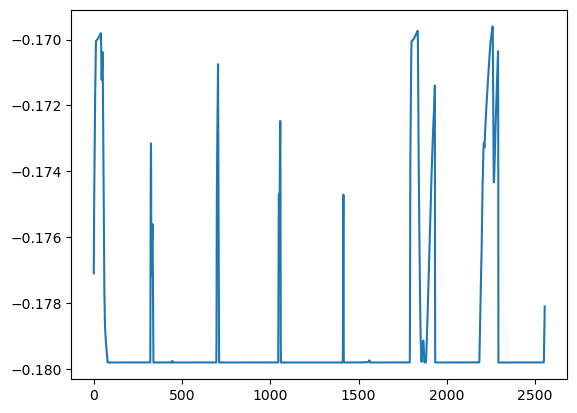

In [53]:
plt.plot(co2_cond)